In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
import itertools
import pystan

In [2]:
N = 2000
D = 2
K = 3
alpha0 = 10000

vizD = 2

In [3]:
def wishart(sigma, dof):
  '''
  Returns a sample from the Wishart distn, conjugate prior for precision matrices.

  (http://www.mit.edu/~mattjj/released-code/hsmm/stats_util.py)

  '''
  n    = sigma.shape[0]
  chol = np.linalg.cholesky(sigma)

  # Use matlab's heuristic for choosing between the two different sampling schemes
  if (dof <= 81+n) and (dof == round(dof)):
      # direct
      X = np.dot(chol,np.random.normal(size=(n,dof)))
  else:
      A = np.diag(np.sqrt(np.random.chisquare(dof - np.arange(0,n),size=n)))
      A[np.tri(n,k=-1,dtype=bool)] = np.random.normal(size=(n*(n-1)/2.))
      X = np.dot(chol,A)

  return np.dot(X,X.T)

def create_cov_ellipse(cov, pos, nstd=2, **kwargs):
  """
  Plots an `nstd` sigma error ellipse based on the specified covariance
  matrix (`cov`). Additional keyword arguments are passed on to the
  ellipse patch artist.

  Parameters
  ----------
    cov : The 2x2 covariance matrix to base the ellipse on
    pos : The location of the center of the ellipse. Expects a 2-element
        sequence of [x0, y0].
    nstd : The radius of the ellipse in numbers of standard deviations.
        Defaults to 2 standard deviations.
    ax : The axis that the ellipse will be plotted on. Defaults to the
        current axis.
    Additional keyword arguments are pass on to the ellipse patch.

  """
  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * np.sqrt(vals)
  ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

  return ellip

In [4]:
# Draw precision matrices from Wishart prior
Lambda = np.zeros((K,D,D))
LambdaInv = np.zeros((K,D,D))
for k in range(K):
    Lambda[k,:,:] = wishart(np.eye(D), 2*D)
    LambdaInv[k,:,:] = np.linalg.inv(Lambda[k,:,:])
# print LambdaInv

In [5]:
# Draw means of Gaussians mixtures [NOT FROM PRIOR!]
mu = np.round(5.5 * np.random.random_sample((K, D)), 2)

# Draw mixing coffecients from Dirichlet prior
pi = np.random.dirichlet(alpha0*np.ones(K))

In [6]:
# Draw data points (training)
y          = np.zeros((N, D))       # observations
Ztrain     = np.zeros((N, K))       # latent variables
labeltrain = np.zeros(N, dtype=int) # label
for n in range(N):
    Ztrain[n,:]    = np.random.multinomial(1, pi)
    labeltrain[n]  = np.argmax(Ztrain[n,:])
    y[n,:]    = np.random.multivariate_normal(
                np.squeeze(mu[labeltrain[n],:]), 
                np.squeeze(LambdaInv[labeltrain[n],:,:]))

y = y - np.mean(y, axis=0)
y = y / 0.5*np.max(np.linalg.norm(y, axis=1))

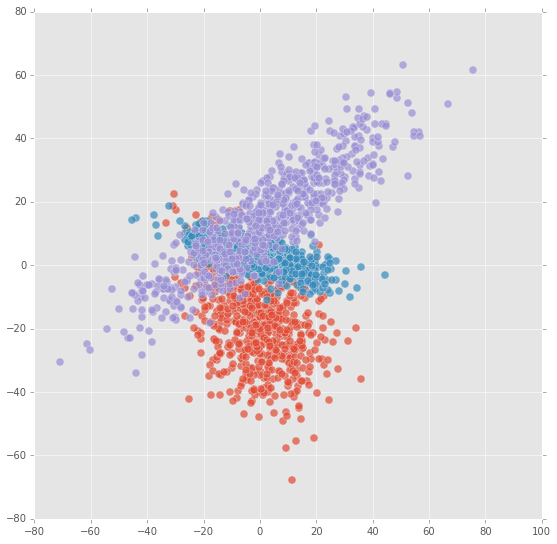

In [7]:
hop = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(vizD, vizD)

for d1 in range(vizD):
    for d2 in range(vizD):
        if d1 < d2:
            ax = plt.subplot(gs[d1, d2])
            ax.scatter(0,0,s=512,color='k',marker='1',lw=3)
            colors = itertools.cycle(plt.rcParams['axes.color_cycle'])
            for i in range(K):
                this_color = next(colors)
                y_i = y[labeltrain==(i)]
                ax.scatter(y_i[:,d1],y_i[:,d2],s=64,c=this_color,alpha=0.7)

In [8]:
datadict = {}
datadict['N']      = N
datadict['D']      = D
datadict['K']      = K
datadict['alpha0'] = alpha0
datadict['y']      = y
pystan.misc.stan_rdump(datadict, 'training.data.R')

In [ ]:
# INSPECT ADVI
results_mf = np.genfromtxt('output_mf.csv', delimiter=',')[1,1:]
# results_mf = np.genfromtxt('intermediate_variational_samples_500.csv', delimiter=',')[1,1:]
pi_mf      = results_mf[0:K]
mu_mf      = np.reshape(results_mf[K:K+K*D], (K,D), order='F')
sigma_mf   = np.reshape(results_mf[K+K*D:], (K,D), order='F')

# results_mf = np.genfromtxt('elbo_mf.csv', delimiter=',', comments='#', skip_header=26)[-1:,3:]
# print results_mf.shape

hop = plt.figure(figsize=(20,20))
gs  = gridspec.GridSpec(vizD, vizD)
for d1 in range(vizD):
    for d2 in range(vizD):
        if d1 < d2:
            ax = plt.subplot(gs[d1, d2])
            colors = itertools.cycle(plt.rcParams['axes.color_cycle'])
            for i in range(K):
                this_color = next(colors)
                y_i = y[labeltrain==(i)]
                ax.scatter(y_i[:,d1],y_i[:,d2],s=64,c=this_color,alpha=0.3)
            for i in range(K):
                ax.scatter(mu_mf[i][d1], mu_mf[i][d2], marker='x', s=256, lw=3, c='k')
                e = create_cov_ellipse(np.diag(np.square(sigma_mf[i][[d1,d2]])), mu_mf[i][[d1,d2]])
                ax.add_artist(e)
                e.set_alpha(1.5*pi_mf[i])
                e.set_facecolor('k')
                
plt.savefig('gmm_advi.pdf',format='pdf')

In [ ]:
# INSPECT NUTS
results_nuts = np.mean(np.genfromtxt('output_nuts.csv', delimiter=',')[1:,6:],axis=0)
pi_nuts      = results_nuts[0:K]
mu_nuts      = np.reshape(results_nuts[K:K+K*D], (K,D), order='F')
sigma_nuts   = np.reshape(results_nuts[K+K*D:], (K,D), order='F')

hop = plt.figure(figsize=(20,20))
gs  = gridspec.GridSpec(vizD, vizD)
for d1 in range(vizD):
    for d2 in range(vizD):
        if d1 < d2:
            ax = plt.subplot(gs[d1, d2])
            colors = itertools.cycle(plt.rcParams['axes.color_cycle'])
            for i in range(K):
                this_color = next(colors)
                y_i = y[labeltrain==(i)]
                ax.scatter(y_i[:,d1],y_i[:,d2],s=64,c=this_color,alpha=0.3)
                ax.scatter(mu_nuts[i][d1], mu_nuts[i][d2], marker='x', s=256, lw=3, c='k')
                e = create_cov_ellipse(np.diag(np.square(sigma_nuts[i][[d1,d2]])), mu_nuts[i][[d1,d2]])
                ax.add_artist(e)
                e.set_alpha(1.5*pi_nuts[i])
                e.set_facecolor('k')
                
plt.savefig('gmm_nuts.pdf',format='pdf')